# Lab 4 - Linear models

We focus on models in the form 

$$ y ~ \mathrm{Normal}(\alpha+X\beta,\sigma) $$

or in generalized form (generalized linear models)

$$ f(y) ~ \mathrm{Normal}(\alpha+X\beta,\sigma) $$

where $f(y)$ is a link function, for example - logit.


In [98]:
from cmdstanpy import CmdStanModel

import random
import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Excercise 1 - modelling height of !Kung people

### Normal model - no predictors
We will try to fit $\mathrm{Normal}(\mu,\sigma)$ distribution to height data. Special case of linear model with $\beta=0$.

In [99]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 

y_height = d["height"].values.tolist()
print(len(y_height))

print(d.head())


352
    height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0


In [100]:
model_ppc=CmdStanModel(stan_file='stanfiles/height_1_ppc.stan')

R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


#### Task 1. Prior predictive checks

1. Plot histograms of mu, sigma and simulated height.
2. Plot a joint distribution of mu and sigma.
3. Check if samples are consistent with priors
4. Check if observed data is possible to obtain using priors.

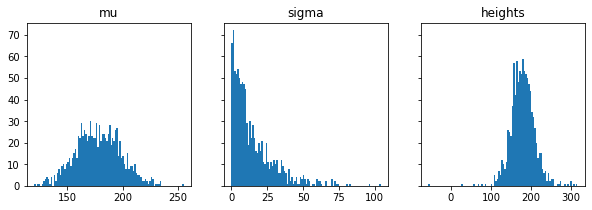

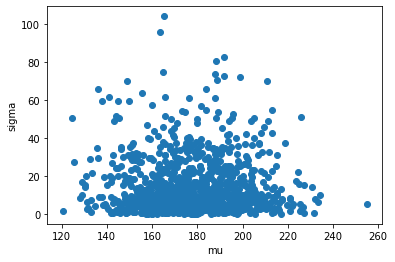

          Mean  MCSE  StdDev      5%    50%    95%   N_Eff   N_Eff/s  R_hat
name                                                                       
lp__       0.0   NaN       0    0.00    0.0    0.0     NaN       NaN    NaN
mu       180.0  0.63      20  140.00  180.0  210.0  1000.0  100000.0    1.0
sigma     15.0  0.48      15    0.74    9.7   44.0   960.0   96000.0    1.0
heights  180.0  0.99      31  130.00  180.0  230.0   950.0   95000.0    1.0


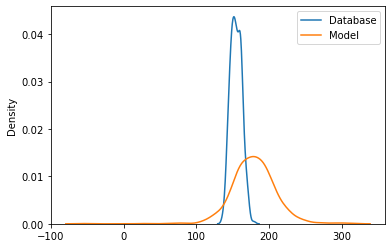

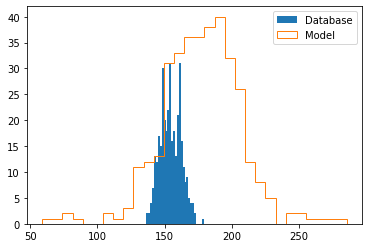

In [101]:
bins = 100
fig, axs = plt.subplots(1,3,sharey=True)
fig.set_size_inches(10,3)
axs[0].hist(sim.stan_variable("mu"),bins=bins)
axs[1].hist(sim.stan_variable("sigma"),bins=bins)
axs[2].hist(sim.stan_variable("heights"),bins=bins)

axs[0].title.set_text("mu")
axs[1].title.set_text("sigma")
axs[2].title.set_text("heights")
#fig.show()
plt.show()

plt.scatter(sim.stan_variable("mu"),sim.stan_variable("sigma"))
plt.xlabel("mu")
plt.ylabel("sigma")
plt.show()

print(sim.summary())

sns.kdeplot(y_height,label="Database")
sns.kdeplot(sim.stan_variable("heights"), label="Model")
plt.legend()
plt.show()


plt.hist(y_height, bins=30, label="Database")
plt.hist(random.sample(sim.stan_variable("heights").tolist(), len(y_height)),bins=30,histtype='step', label="Model")
plt.legend()
plt.show()


In [102]:
model_1_fit=CmdStanModel(stan_file='stanfiles/height_1_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [103]:
fit=model_1_fit.sample(data=dict(N=len(d),
                                   heights=d.height.values),
                         seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


#### Task 2. Model fit and evaluation

1. Plot a joint distribution of fitted mu and sigma.
2. Plot histograms of data and simulated heights and evaluate the quality of model.



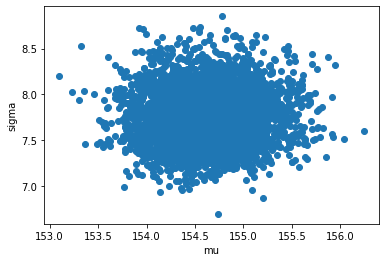

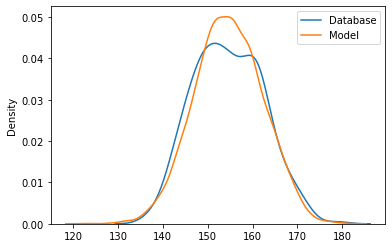

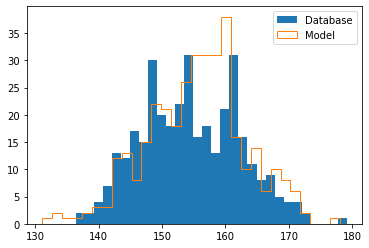

In [104]:
plt.scatter(fit.stan_variable("mu"),fit.stan_variable("sigma"))
plt.xlabel("mu")
plt.ylabel("sigma")
plt.show()



sns.kdeplot(y_height,label="Database")
sns.kdeplot(fit.stan_variable("height"), label="Model")
plt.legend()
plt.show()


plt.hist(y_height, bins=30, label="Database")
plt.hist(random.sample(fit.stan_variable("height").tolist(), len(y_height)),bins=30,histtype='step', label="Model")
plt.legend()
plt.show()

### Adding predictor to the model - weight

Create column ```c_weight``` in the dataframe containing weights substrated by their mean.


In [105]:
model_ppc=CmdStanModel(stan_file='stanfiles/height_2a_ppc.stan')
R = 1000

d["c_weight"] = d["weight"] - d["weight"].mean()

data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max())}
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


#### Task 4. Prior predictive checks
1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

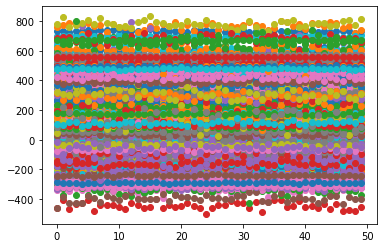

In [106]:
draws=sim.draws_pd()
draws_iloc=draws.iloc[:, 5:]
l=[]
x=[]
for i in range(50):
    l.append(draws_iloc.iloc[:,i].tolist())
    x.append(np.linspace(i,i,num=1000))

plt.plot(x,l,'o')
plt.show()

### Modifying prior

If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.


In [107]:
model_ppc=CmdStanModel(stan_file='stanfiles/height_2b_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [108]:
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


#### Task 5. Prior predictive checks
1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.
2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?

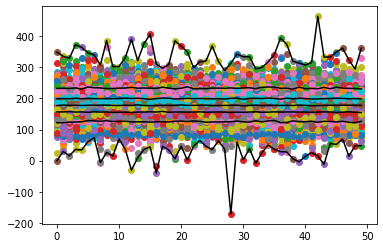

In [109]:
draws=sim.draws_pd()
draws_iloc=draws.iloc[:,5:]
l=[]
x=[]
mini=[]
maxi=[]

quantiles = {5:[], 25:[], 50: [], 75: [], 95: []}
for i in range(50):
    
    x.append(np.linspace(i,i,num=1000))

    l1=draws_iloc.iloc[:,i].tolist()
    l.append(l1)
    ar=np.array(l1)

    mini.append(np.quantile(ar,0))
    maxi.append(np.quantile(ar,1))
    quantiles[5].append(np.quantile(ar,0.05))
    quantiles[25].append(np.quantile(ar,0.25))
    quantiles[50].append(np.quantile(ar,0.50))
    quantiles[75].append(np.quantile(ar,0.75))
    quantiles[95].append(np.quantile(ar,0.95))
    
    
plt.plot(x,l,'o')
plt.plot(mini,'k')
plt.plot(maxi,'k')

for quant in quantiles:
    plt.plot(quantiles[quant],'k')
plt.show()

### Fitting data


In [110]:
model_2_fit=CmdStanModel(stan_file='stanfiles/height_2_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


#### Task 6. Preparing data for fit
1. Create ```data_fit``` dictionary containing data from  ```N``` first rows of dataframe

In [120]:
N = len(d)
N = 50

data_fit = {"N":N, "weight": random.sample(d["weight"].tolist(),N), "heights": random.sample(d["height"].tolist(),N)}
fit=model_2_fit.sample(data=data_fit,seed=28052020)

def task6(db, N=10):
    data_fit = {"N":N, "weight": random.sample(db["weight"].tolist(),N), "heights": random.sample(db["height"].tolist(),N)}
    fit=model_2_fit.sample(data=data_fit,seed=28052020)
    return fit
    pass

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)





chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


#### Task 7. Evaluating model

1. Plot lines for each sampled slope beta and intercept alpha. Verify how uncertainity changes with increasing of sample (N)
2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data (N points). Is observed data possible within the posterior model? What changes when N increases.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


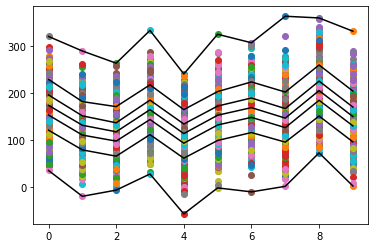

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


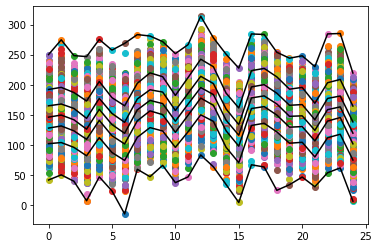

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)



chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


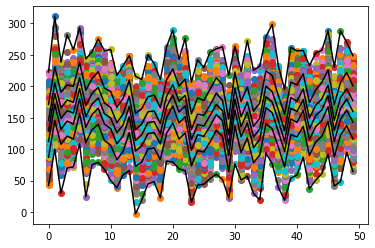

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |█████████ | 00:01 Iteration: 1700 / 2000 [ 85%]  (Sampling)





chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


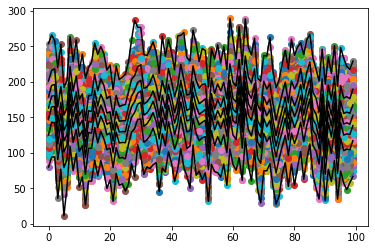

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:01 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▋ | 00:01 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |█████████▌| 00:02 Iteration: 1800 / 2000 [ 90%]  (Sampling)







chain 1 |██████████| 00:02 Sampling completed                       
chain 2 |██████████| 00:02 Sampling completed                       
chain 3 |██████


INFO:cmdstanpy:CmdStan done processing.


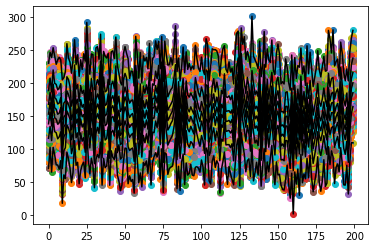

In [121]:

def task7(fit,N):
    draws=fit.draws_pd()
    draws_iloc=draws.iloc[:, (N+10):]
    l=[]
    x=[]
    mini=[]
    maxi=[]

    quantiles = {5:[], 25:[], 50: [], 75: [], 95: []}

    for i in range(N):
        x.append(np.linspace(i,i,num=4000))

        l1=draws_iloc.iloc[:,i].tolist()
        l.append(l1)
        ar=np.array(l1)

        mini.append(np.quantile(ar,0))
        maxi.append(np.quantile(ar,1))
        
        quantiles[5].append(np.quantile(ar,0.05))
        quantiles[25].append(np.quantile(ar,0.25))
        quantiles[50].append(np.quantile(ar,0.50))
        quantiles[75].append(np.quantile(ar,0.75))
        quantiles[95].append(np.quantile(ar,0.95))
        
    plt.plot(x,l,'o')
    plt.plot(mini,'k')
    plt.plot(maxi,'k')

    for quant in quantiles:
        plt.plot(quantiles[quant],'k')
    plt.show()


N = [10, 25, 50, 100, 200]

for n in N:
    task7(task6(d,n),n)